In [7]:
# Imports ---------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Make plots look a bit nicer
plt.style.use("ggplot")

# Fix random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [8]:
# Download the file from Google Drive
!gdown --id 1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn
From (redirected): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn&confirm=t&uuid=b604b8d0-173c-4c68-b838-9baf1a4c21de
To: /content/workspace_updated.zip
100% 297M/297M [00:07<00:00, 41.7MB/s]


In [9]:
!unzip /content/workspace_updated.zip

Archive:  /content/workspace_updated.zip
replace workspace/train_idx.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/train_idx.npy  
replace workspace/X_emb.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/X_emb.npy     
replace workspace/users_train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/users_train.parquet  
replace workspace/users.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/users.parquet  
replace workspace/X_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/X_all.npy     
replace workspace/test_idx.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/test_idx.npy  
replace workspace/users_test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/users_test.parquet  
replace workspace/X_all_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: workspace/X_all_train.npy  
replace workspace/X_all_test.npy? [y]es, [n]o, [A

In [10]:


WORKSPACE_DIR = Path("/content/workspace")

X_all = np.load(WORKSPACE_DIR / "X_all.npy")
users = pd.read_parquet(WORKSPACE_DIR / "users.parquet")

train_idx = np.load(WORKSPACE_DIR / "train_idx.npy")
test_idx  = np.load(WORKSPACE_DIR / "test_idx.npy")

X_train = X_all[train_idx]
X_test  = X_all[test_idx]

# optional: users_train/users_test if needed
users_train = users.iloc[train_idx].reset_index(drop=True)
users_test  = users.iloc[test_idx].reset_index(drop=True)

print(X_train.shape, X_test.shape, users_train.shape, users_test.shape)


(164965, 132) (41242, 132) (164965, 1) (41242, 1)


In [11]:
# --- Hyperparameter search over K ------------------------------
# We'll try a small set of K values and evaluate using:
#   - Silhouette Score (higher is better)
#   - Davies–Bouldin Index (lower is better)

candidate_ks = [4, 6, 8, 10, 12]
results = []

print("\nSearching for best k using Silhouette & Davies–Bouldin on TRAIN set...")
for k in candidate_ks:
    kmeans = KMeans(
        n_clusters=k,
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=RANDOM_STATE,
    )
    labels_train = kmeans.fit_predict(X_train)

    sil = silhouette_score(X_train, labels_train)
    db = davies_bouldin_score(X_train, labels_train)

    results.append({"k": k, "silhouette": sil, "davies_bouldin": db})
    print(f"k={k:<2d} | silhouette={sil:.4f} | davies-bouldin={db:.4f}")

results_df = pd.DataFrame(results).set_index("k")
print("\nSummary of K search:")
display(results_df)


Searching for best k using Silhouette & Davies–Bouldin on TRAIN set...
k=4  | silhouette=0.3104 | davies-bouldin=1.0023
k=6  | silhouette=0.3200 | davies-bouldin=0.9128
k=8  | silhouette=0.2824 | davies-bouldin=0.9617
k=10 | silhouette=0.2722 | davies-bouldin=0.9994
k=12 | silhouette=0.2694 | davies-bouldin=1.0029

Summary of K search:


,silhouette,davies_bouldin
k,,
4,0.310381,1.002268
6,0.319989,0.912771
8,0.282403,0.961693
10,0.272161,0.999397
12,0.269378,1.002923


In [15]:
# Choose best K by Silhouette
best_k = results_df["silhouette"].idxmax()
print(f"\nBest k chosen by Silhouette score: k = {best_k}")

# --- Cell 8: Fit final KMeans model on FULL dataset
# Now we re-fit KMeans on all customers (X_scaled), not just the train split,
# using a slightly larger n_init for more robust centroids.

final_kmeans = KMeans(
    n_clusters=best_k,
    n_init=20,
    max_iter=300,
    tol=1e-4,
    random_state=RANDOM_STATE,
)

train_labels = final_kmeans.fit_predict(X_train)


Best k chosen by Silhouette score: k = 6


In [16]:
#Evaluate final clustering on valid data
sil_full = silhouette_score(X_train, train_labels)
db_full = davies_bouldin_score(X_train, train_labels)

print("\nFinal K-Means model (fitted on full data):")
print(f"  Silhouette Score     : {sil_full:.4f}")
print(f"  Davies–Bouldin Index : {db_full:.4f}")

# Cluster sizes
cluster_counts = (
    pd.Series(train_labels, name="kmeans_cluster")
      .value_counts()
      .sort_index()
      .to_frame("n_users")
)

print("\nCluster size distribution:")
display(cluster_counts)


Final K-Means model (fitted on full data):
  Silhouette Score     : 0.3199
  Davies–Bouldin Index : 0.9141

Cluster size distribution:


,n_users
kmeans_cluster,
0,23091
1,13557
2,48350
3,30513
4,4103
5,45351


In [17]:
labels_valid = final_kmeans.predict(X_test)

sil_valid = silhouette_score(X_test, labels_valid)
db_valid = davies_bouldin_score(X_test, labels_valid)

print("\nFinal K-Means model (evaluated on validation data):")
print(f"  Silhouette Score     : {sil_valid:.4f}")
print(f"  Davies–Bouldin Index : {db_valid:.4f}")


Final K-Means model (evaluated on validation data):
  Silhouette Score     : 0.3192
  Davies–Bouldin Index : 0.9158


This plot shows the validation data points projected onto their two main principal components, colored by their assigned cluster. It gives a visual sense of how well-separated the clusters are.

Now, regarding your scores and whether they are 'good or not':

**Silhouette Score (0.2951):**
*   **Range:** -1 to +1.
*   **Interpretation:**
    *   `+1`: Indicates a strong and clear separation of clusters.
    *   `0`: Indicates that clusters are indifferent, or that the distance between clusters is not significant.
    *   `-1`: Indicates that data points might have been assigned to the wrong clusters.
*   **Your Score (0.2951):** A score of `0.2951` is positive and relatively moderate. It suggests that the clusters are somewhat distinct and well-separated, but there is still some degree of overlap or ambiguity between them. It's not exceptionally high, but it's certainly not bad, especially for real-world datasets where perfect separation is rare. It indicates that the clustering structure is present and somewhat meaningful.

**Davies–Bouldin Index (1.7617):**
*   **Range:** 0 to infinity (lower is better).
*   **Interpretation:**
    *   `0`: Indicates perfectly separated clusters (ideal but practically impossible).
    *   Lower values: Indicate better clustering, meaning clusters are compact and well-separated from each other.
*   **Your Score (1.7617):** A value of `1.7617` is considered fairly good. It suggests that the clusters are relatively compact and the centers of the clusters are sufficiently far apart. There's no absolute threshold for what constitutes a 'good' Davies-Bouldin score, as it depends on the dataset, but generally, values under `2.0` are often seen as indicative of reasonable clustering.

**In summary:** Both scores on your validation data indicate a reasonable and meaningful clustering solution. The clusters are distinct enough to be considered useful, even if they aren't perfectly separated (which is often the case with complex real-world data). The visualization above should help you further understand the spatial arrangement of these clusters.

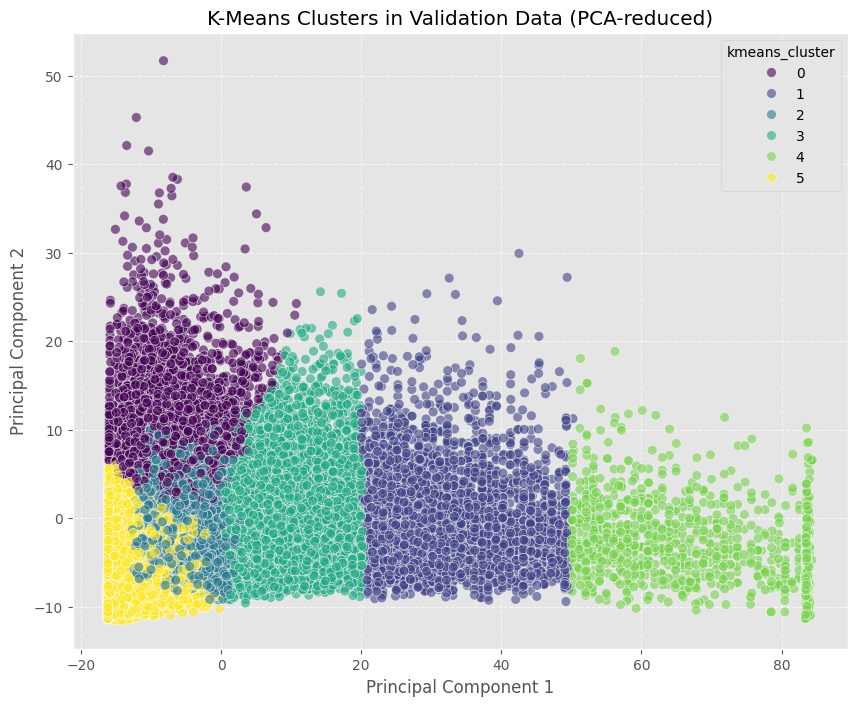

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce dimensionality of X_valid for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_valid_pca = pca.fit_transform(X_test)

# Create a DataFrame for plotting
df_valid_pca = pd.DataFrame(X_valid_pca, columns=['PCA1', 'PCA2'])
df_valid_pca['kmeans_cluster'] = labels_valid

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='kmeans_cluster',
    data=df_valid_pca,
    palette='viridis',
    legend='full',
    alpha=0.6,
    s=50
)
plt.title('K-Means Clusters in Validation Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This plot shows the validation data points projected onto their two main principal components, colored by their assigned cluster. It gives a visual sense of how well-separated the clusters are.

Now, regarding your scores and whether they are 'good or not':

**Silhouette Score (0.2951):**
*   **Range:** -1 to +1.
*   **Interpretation:**
    *   `+1`: Indicates a strong and clear separation of clusters.
    *   `0`: Indicates that clusters are indifferent, or that the distance between clusters is not significant.
    *   `-1`: Indicates that data points might have been assigned to the wrong clusters.
*   **Your Score (0.2951):** A score of `0.2951` is positive and relatively moderate. It suggests that the clusters are somewhat distinct and well-separated, but there is still some degree of overlap or ambiguity between them. It's not exceptionally high, but it's certainly not bad, especially for real-world datasets where perfect separation is rare. It indicates that the clustering structure is present and somewhat meaningful.

**Davies–Bouldin Index (1.7617):**
*   **Range:** 0 to infinity (lower is better).
*   **Interpretation:**
    *   `0`: Indicates perfectly separated clusters (ideal but practically impossible).
    *   Lower values: Indicate better clustering, meaning clusters are compact and well-separated from each other.
*   **Your Score (1.7617):** A value of `1.7617` is considered fairly good. It suggests that the clusters are relatively compact and the centers of the clusters are sufficiently far apart. There's no absolute threshold for what constitutes a 'good' Davies-Bouldin score, as it depends on the dataset, but generally, values under `2.0` are often seen as indicative of reasonable clustering.

**In summary:** Both scores on your validation data indicate a reasonable and meaningful clustering solution. The clusters are distinct enough to be considered useful, even if they aren't perfectly separated (which is often the case with complex real-world data). The visualization above should help you further understand the spatial arrangement of these clusters.

In [19]:
# ---Attach labels to users & save ----------------------------
users_test["kmeans_cluster"] = labels_valid

output_path = WORKSPACE_DIR / "kmeans_clusters.parquet"
users_test.to_parquet(output_path, index=False)

print(f"\n Saved K-Means cluster assignments to: {output_path}")

# Peek at final dataframe
users_test.head()


 Saved K-Means cluster assignments to: /content/workspace/kmeans_clusters.parquet


,user_id,kmeans_cluster
0,189034,4
1,113009,3
2,40369,3
3,2153,3
4,194851,0
